# Custom Radius and Wavelength-Dependent Aerosol Layers

In this tutorial you will learn: 

1. How to generate your own Mie coefficients for a given radius grid
2. How to compute the optics of an aerosol for your custom radius grid
3. How to inject this aerosol as a custom layer into an atmospheric model for PICASO

You need to have downloaded PICASO, Virga, and the particle size distribution file to run this tutorial.

First, let's import all the necessary packages:

In [18]:
#standards
import numpy as np
import pandas as pd
import astropy.units as u



import warnings
warnings.filterwarnings('ignore')
#main programs

#radiative transfer and atmosphere code
from picaso import justdoit as pdi

#cloud code
from virga import justdoit as vdi


#plotting tools
from picaso import justplotit as ppi
from virga import justplotit as vpi
ppi.output_notebook() 

import matplotlib.pyplot as plt

Loading BokehJS ...

Now, let's load in a sample particle size distribution. 
This one comes from [He et al., 2018](https://iopscience.iop.org/article/10.3847/2041-8213/aab42b), on the sizes of hazes produced in a laboratory setting. Notice that these are given in particle diameter, so we have to convert them to radii.

In [14]:
from inspect import getsourcefile
from os.path import abspath
#if you haven't installed virga from github this file will exist in your libary package here
particle_distribution_file = os.path.join(
    str(abspath(getsourcefile(vpi)).replace('justplotit.py','')),'reference','particle_sizes.csv')
#all this does is grab the code directory to get the reference data location of the code  

In [15]:
particle_distribution = pd.read_csv(particle_distribution_file)

n_400K, n_300K, size = particle_distribution['400 K'], particle_distribution['300 K'], particle_distribution['size (nm)'] 

#cut the range of sizes where there aren't any data points
non_nans_400 = np.where(np.isfinite(n_400K))
non_nans_300 = np.where(np.isfinite(n_300K))

n4 = n_400K.iloc[non_nans_400]
r4 = size.iloc[non_nans_400]

n3 = n_300K.iloc[non_nans_300]
r3 = size.iloc[non_nans_300]

#turn them into arrays for handy plotting and convert the particle diameters into radii
r4=np.array(r4/2)
n4=np.array(n4)
r3=np.array(r3/2)
n3=np.array(n3)

Let's plot up the distribution so we can see what it looks like

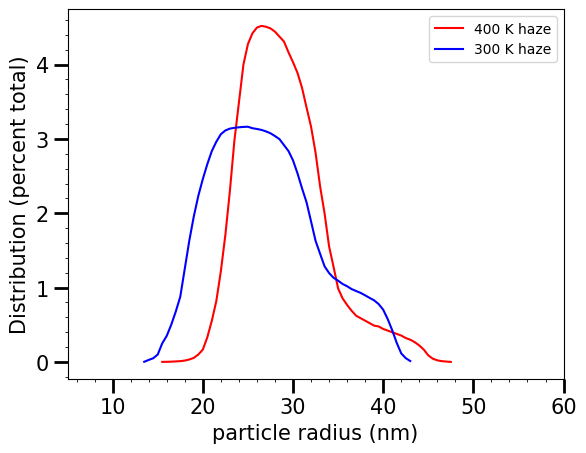

In [19]:
plt.plot(r4,n4,color='red',label='400 K haze')
plt.plot(r3,n3,color='blue',label = '300 K haze')
plt.xlim(5,60)

plt.xlabel('particle radius (nm)',fontsize=15)
plt.ylabel('Distribution (percent total)',fontsize=15)
plt.minorticks_on()
plt.tick_params(axis='y',which='major',length =10, width=2,direction='out',labelsize=15)
plt.tick_params(axis='x',which='major',length =10, width=2,direction='out',labelsize=15)
plt.legend()

Okay, looks good! Now we have to compute a custom set of Mie coefficients that correspond to these particle radii. Make sure you **stick these new Mie databases in a new folder so you don't overwrite your existing Virga databases!** We're going to use the refractive indices of Titan-like tholins from [Khare et al., 1984](https://www.sciencedirect.com/science/article/abs/pii/0019103584901428?via%3Dihub) just for example purposes. Make sure you have this set of Refractive Indices in your version of Virga.

In [7]:
#Remember to change these paths to where your refractive indices and Mie databases live
mieff_dir = '/Users/nbatalh1/Documents/data/virga/virga_tholins/'
# here I am assuming the refractive indices are stored in the same place as I want the output
refrind_dir = output_dir = mieff_dir 

#First, let's just assume our hazes follow the distribution of the 300 K haze above.

#Note that this function wants the radii in centimeters, so we have to convert it from nanometers
newmies=vdi.calc_mie_db('khare_tholins', refrind_dir, output_dir, 
                        rmin = np.min(r3/1e7), rmax=np.max(r3/1e7), nradii = len(r3))


Computing khare_tholins


Okay, now let's grab those Mieff coefficients we just calculated.

In [8]:

qext, qscat, cos_qscat, nwave, radius, wave_in = vdi.get_mie('khare_tholins',directory=mieff_dir)

Next, we calculate our optical properties. Remember that **r3** here is your grid of radii bins and **n3** is the distribution of particles per radius bin.

**ndz** is the total number of particles that make up our aerosol layer. Since we're setting our own slab, it's not really physical in this implementation because we're setting the particle number over many atmospheric layers. So we're going to set it fairly high.

In [9]:
ndz = 5e9 #that's particles/cm^2 but over the entire region of atmosphere where we're sticking aerosol

opd,w0,g0,wavenumber_grid=vdi.calc_optics_user_r_dist(wave_in, ndz ,r3, u.nm, n3/100, 
                                                      qext, qscat, cos_qscat, )

Now, we need to turn the above variables into something that PICASO can read. Choose where to set your aerosol layer pressure limits. 

In [14]:
nlayer = 30
base_pressure = 1e-1 # let's start by setting the haze layer base at 0.1 bars
haze_top_pressure = 1e-7 #and set the top of the haze layer at 0.1 microbar. Not unreasonble for a haze that forms fairly high!

#just set an arbitrary pressure grid from 1000 bars to a nanobar
pressure =  np.logspace(-9,3,nlayer)

#here's where we shove all the variables into a dataframe PICASO can read
df_haze = vdi.picaso_format_slab(base_pressure,opd, w0, g0, wavenumber_grid, pressure,p_top=haze_top_pressure)


nwno = len(wavenumber_grid) #this will depend on the refractive indices you have. Khare's tholin have wide coverage but low resolution
ppi.show(ppi.plot_cld_input(nwno, nlayer,df=df_haze))

We can see that lovely slab of haze and how it's changing according to wavelength! The above plots aren't in physical units though. Let's change the axes to be real numbers and not gridpoints. The wavelength grid covers a lot, so you'll probably have to zoom in to see the wavelength units.

In [16]:
ppi.show(ppi.plot_cld_input(nwno, nlayer,df=df_haze,pressure=pressure, wavelength=1e4/wavenumber_grid))

Now let's see how that would look in a spectrum. First, let's load a couple basic planet parameters.

In [38]:
nlevel = nlayer+1
opa = pdi.opannection(wave_range=[0.3,14])
case1 = pdi.inputs()

case1.phase_angle(0)


#here we are going to have to specify gravity through R and M since we need it in the Flux calc
case1.gravity(mass=1, mass_unit=pdi.u.Unit('M_jup'),
              radius=1.2, radius_unit=pdi.u.Unit('R_jup'))

#here we are going to have to specify R as well
case1.star(opa, 4000,0.0122,4.437,radius=0.7, radius_unit = pdi.u.Unit('R_sun') )

#atmo -- make sure your pressure grid matches the one you computed your haze on!
case1.atmosphere( df = pdi.pd.DataFrame({'pressure':np.logspace(-9,3,nlevel),
                                                 'temperature':np.logspace(-9,3,nlevel)*0+600, #just an isothermal one for simplicity
                                                 "H2":np.logspace(-9,3,nlevel)*0+0.837,
                                                 "He":np.logspace(-9,3,nlevel)*0+0.163,
                                                 "H2O":np.logspace(-9,3,nlevel)*0+0.00034,
                                                 "CH4":np.logspace(-9,3,nlevel)*0+0.000466}))

And compute and plot our clear transmission spectrum, without our haze:

In [39]:

df= case1.spectrum(opa, full_output=True,calculation='transmission')

wno, rprs2  = df['wavenumber'] , df['transit_depth']
wno, rprs2 = pdi.mean_regrid(wno, rprs2, R=300)
full_output = df['full_output']

ppi.show(ppi.spectrum(wno,rprs2*1e6,plot_width=500))


Now, let's add in that hazy information. We need to make sure the pressure grids match (by reducing the layers by one because of PICASO's idiosyncrasies).

In [42]:
#pressure =  np.logspace(-9,3,30)
#pressure = pressure[:-1]
#df_haze = vdi.picaso_format_wavelength_dependent_slab(base_pressure,haze_top_pressure,
#                                                      opd, w0, g0, wavenumber_grid, pressure)


case1.clouds(df=df_haze)
hazy= case1.spectrum(opa, full_output=True,calculation='transmission')
hazyx,hazyy =hazy['wavenumber'] , hazy['transit_depth']
hazyx,hazyy = pdi.mean_regrid(hazyx,hazyy, R=300)

Let's compare our hazy spectrum to our clear spectrum!

In [45]:
ppi.show(ppi.spectrum([wno,hazyx],[(rprs2*1e6),(hazyy*1e6)],
                  legend=['clear','hazy'],plot_width=900,plot_height=300))

This is a very hazy run, wow! In the visibile and NIR, the haze creates a bigger scattering slope and mutes the water features at Hubble WFC3/IR wavelengths.

With this amount of haze, we can actually see IR features in the spectrum that are due to the haze itself. At 4.6 microns, we see absorption due to nitrile functional groups (C=N bonds) and from 2.8 to almost 4 microns we see a large, broad amine (N-H) feature. 